In [2]:
import json
import os
import pandas as pd
import numpy as np
from pathlib import Path
import collections
from sklearn.model_selection import train_test_split
from sklearn import metrics

import sys
sys.path.append("../")
from datatools.analyzer import *
from utterance.error_tools import *

from datatools.maneger import DataManager
from datatools.preproc import Preprocessor

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules import loss
import torch.optim as optim
import torch.nn.utils.rnn as rnn

In [307]:
path = "../hand_labeled/"
datalist = ['DCM', 'DIT', 'IRS']
convs = read_conv(path, datalist)

In [311]:
def make_Xy_4test(convs, N=4):
    # errors = ["Topic transition error", 'Lack of information', 'Unclear intention']
    errors = ["Unclear intention"]
    X = []
    y = []
    for conv in convs:
        dialogue = [""]*N
        for i, ut in enumerate( conv ) :
            # ユーザ発話駆動
            dialogue.append(clean_text( ut.utt) )
            if ut.is_exist_error():
                X.append( dialogue[-N:] )
                    # X.append(dialogue[-N:])
                if ut.is_error_included(errors) :
                    y.append(1)
                else:
                    y.append(0)
        
    return X, y

In [312]:
N = 3
X_str, y = make_Xy_4test(convs, N=N)

In [313]:
y.count(1)

474

In [269]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, tagset_size, vocab_dict):
        # 親クラスのコンストラクタ。決まり文句
        super(LSTMClassifier, self).__init__()
        # 隠れ層の次元数。これは好きな値に設定しても行列計算の過程で出力には出てこないので。    
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim,  padding_idx=0)
        # モデルを2つ定義
        self.lstm1 = nn.LSTM(embedding_dim, hidden_dim//2, batch_first=True,  bidirectional=True )
        # self.lstm2 = nn.LSTM(embedding_dim, hidden_dim//2, batch_first=True,  bidirectional=True )
        self.hidden2tag = nn.Linear(hidden_dim , tagset_size)
        # softmaxのLog版。dim=0で列、dim=1で行方向を確率変換。
        self.softmax = nn.LogSoftmax()
    
        self.vocab_dict = vocab_dict
    
    def forward(self, x):
        emb1 = self.word_embeddings(x)
        _, lstm1_out = self.lstm1(emb1)
        tag_space = self.hidden2tag(torch.cat([ lstm1_out[0][0], lstm1_out[0][1]], dim=1 ))
        y =self.softmax(tag_space)
        return y
    
    def last_context(self, x):
        emb1 = self.word_embeddings(x)
        # print(emb1.shape)
        _, lstm1_out = self.lstm1(emb1)
        context = torch.cat([ lstm1_out[0][0], lstm1_out[0][1]], dim=1 )
        return context
    
    def text2context(self, text):
        if isinstance(text, str):
            utt_id = self._sentence2ids(text, self.vocab_dict)
            utt_id_tensor = torch.tensor( [utt_id] , device='cuda:0', dtype=torch.int)
            # utt_id_tensor = torch.tensor( [utt_id] , device='cpu', dtype=torch.int)
            return self.last_context(utt_id_tensor)
        if isinstance(text, list):
            X = self._make_X(text, self.vocab_dict)
            utt_id_tensor = X.to(torch.int).cuda()
            # utt_id_tensor = X.to(torch.int)
            return self.last_context(utt_id_tensor)
        else:
            return 0

        
    def _sentence2ids(self, sentence:str, vocab_dict:dict):
        doc = self._sentence2formated(sentence)
        ids = np.zeros(len(doc))
        for i, key in enumerate(doc):
            # key = token.orth_
            if key in vocab_dict:
                ids[i] = vocab_dict[key]
            else:
                ids[i] = vocab_dict["[UNK]"]
        return ids
    
    def _sentence2formated(self, sen):
        return sum( fill_SYMBOL_ONE( sentence2normalize_noun(sen) ), [] )
    
    def _padding_vector(self, Xseq):
        Xseq = [ torch.tensor( xseq[:, None] ) for xseq in Xseq]
        Xseq = rnn.pad_sequence(Xseq, batch_first=True)
        Xseq = [ torch.flatten(xseq) for xseq in Xseq ] 
        return Xseq


    def _make_X(self, utt_list:list, vocab_dict:dict):
        utt_id_list = []
        for utt in tqdm( utt_list) :
            utt_id = self._sentence2ids(utt, vocab_dict)
            utt_id_list.append(utt_id)

        utt_id_pad = self._padding_vector(utt_id_list)
        upl = len(utt_id_pad[0])
        # X =   [ torch.Tensor([u, s]) for u, s in zip(usr_id_pad, sys_id_pad) ] 
        # print(usr_pad_len, sys_pad_len)
        X = torch.zeros( (len(utt_list), upl) )
        for i, u in enumerate(utt_id_pad):
            X[i, :upl] = u
        return X

In [270]:
model_path = "../models/response2/"
model_name = "forward_v2.pickle"
modelM = DataManager(model_path)
fmodel = modelM.load_data(model_name)

success load : ../models/response2/forward_v2.pickle


In [271]:
# forward_xy_name = "../X_y_data/context_topic/X_forward_topic_ERROR_N={0}".format(N)
forward_xy_name = "../X_y_data/context_topic/X_forward_topic_ERROR_N={0}".format(N)

In [272]:
X_forward_all_str = sum(X_str, [])

if os.path.exists(forward_xy_name+".npy"):
    # X_forward_ids  = np.load(forward_xy_name+".npy")
    X_forward  = np.load(forward_xy_name+".npy")
    print("success load {0}.npy".format(forward_xy_name))
else:
    with torch.no_grad():
        fmodel.cpu()
        # X_forward_l =  fmodel.text2context(X_str)
        # 手で書くしかない
        x_length = len(X_forward_all_str)//N
        X_forward_ids = fmodel._make_X(X_forward_all_str, fmodel.vocab_dict).to(torch.int)
        X_forward_ids = X_forward_ids.reshape(x_length, N, -1)
        X_forward = np.array( [fmodel.last_context(Xfi).numpy() for Xfi in X_forward_ids] ) 
        # X_forward = X_forward.reshape(-1, 4, 256)
        fmodel.cuda()
        # X_forward_l = np.array( fmodel.text2context(X_forward_all_str).cpu() ) 
        # np.save(forward_xy_name, X_forward_ids)
        np.save(forward_xy_name, X_forward)
    

100%|██████████| 4047/4047 [01:45<00:00, 38.25it/s]


In [273]:
from sentence_transformers import SentenceTransformer
from sentence_transformers import models

download_path = "../../corpus/"
# download_path = ""
transformer = models.Transformer(download_path+'cl-tohoku/bert-base-japanese-whole-word-masking')
pooling = models.Pooling(transformer.get_word_embedding_dimension(),    
  pooling_mode_mean_tokens=True,
  pooling_mode_cls_token=False, 
  pooling_mode_max_tokens=False
)
smodel = SentenceTransformer(modules=[transformer, pooling])

sentences = ['吾輩は猫である']
embeddings = smodel.encode(sentences)


Some weights of the model checkpoint at ../../corpus/cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[1340] 2022-01-12 16:17:10,031 Info sentence_transformers.SentenceTransformer :Use pytorch device: cuda


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [274]:
from sentence_transformers import SentenceTransformer
# from sentence_transformers import models

bert_path = "../../corpus/pretrained/sbert_unclear1"
sbert = SentenceTransformer(bert_path)

[1340] 2022-01-12 16:17:10,751 Info sentence_transformers.SentenceTransformer :Load pretrained SentenceTransformer: ../../corpus/pretrained/sbert_unclear1
[1340] 2022-01-12 16:17:13,120 Info sentence_transformers.SentenceTransformer :Use pytorch device: cuda


In [275]:
emb_dim = embeddings.shape[1]

In [276]:
x_length = len(X_forward_all_str)//N
# X_topic_vec = smodel.encode(X_forward_all_str).reshape(x_length, N, -1)
X_topic_vec = sbert.encode(X_forward_all_str).reshape(x_length, N, -1)

Batches:   0%|          | 0/127 [00:00<?, ?it/s]

In [277]:
def vec2feature(vector):
    diff = np.abs( vector[0] - vector[1] )
    return np.concatenate([vector.flatten(), diff])

In [278]:
def sentence2formated(vectors):
    features = []
    prev_vector = np.zeros(emb_dim)
    for i, vector in enumerate(vectors):
        feature = vec2feature( np.array([prev_vector, vector]) ) 
        features.append(feature)
        prev_vector = vector
    return np.array(features)

In [279]:
X_topic = np.array([ sentence2formated(vec) for vec in X_topic_vec ])

In [280]:
X_topic.shape

(1349, 3, 2304)

In [281]:
# X = np.concatenate([X_topic, X_forward_ids], axis=2)
X = np.concatenate([X_topic, X_forward], axis=2)
X = torch.from_numpy(X)
y = torch.Tensor(y)

In [282]:
topic_len = emb_dim*3

In [315]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=5, stratify=y)

In [316]:
class Datasets(torch.utils.data.Dataset):
    def __init__(self, X_data, y_data):
        # self.transform = transform

        self.X_data = X_data
        self.y_data = y_data

        self.datanum = len(X_data)

    def __len__(self):
        return self.datanum

    def __getitem__(self, idx):
        out_X = self.X_data[idx]
        out_y = self.y_data[idx]

        return out_X, out_y

In [317]:
import copy
class TopicClassifier(nn.Module):
    def __init__(self, topic_dim, forward_dim, hidden_dim, hidden_dim2, tagset_size, fmodel_path="../models/response2/"):
        # 親クラスのコンストラクタ。決まり文句
        super(TopicClassifier, self).__init__()
        # 隠れ層の次元数。これは好きな値に設定しても行列計算の過程で出力には出てこないので。    
        self.tlen = topic_dim
        self.flen = forward_dim
        self.hidden = hidden_dim
        self.tlstm = nn.LSTM(topic_dim, hidden_dim, batch_first=True)
        self.lay2_lstm = nn.LSTM(hidden_dim+forward_dim//2, hidden_dim2, batch_first=True)
        self.for2hid = nn.Linear(forward_dim , forward_dim//2)
        self.hid2out = nn.Linear(hidden_dim2 , tagset_size)
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax()

        # fmodel_name = "forward_v2.pickle"
        # modelM = DataManager(fmodel_path)
        # self.fmodel = modelM.load_data(fmodel_name)

    def forward(self, x):
        x_topic = x[:, :, :self.tlen].to(torch.float)
        # x_forward_id = x[:, :, self.tlen:].to(torch.int)
        x_forward = x[:, :, self.tlen:].to(torch.float)
        x_for_hid = self.for2hid(x_forward)
        # print(x_topic.shape)

        # forward_c = torch.stack( [ self.fmodel.last_context(xfid) for xfid in x_forward_id])
        topic_out, _ = self.tlstm(x_topic)
        # print("topic_out: ", topic_out.shape)
        topic_out = self.relu(topic_out)
        # x_lay2 = torch.cat([topic_out, forward_c], dim=2)
        # x_lay2 = torch.cat([topic_out, x_forward], dim=2)
        x_lay2 = torch.cat([topic_out, self.relu(x_for_hid)], dim=2)
        # print("x_lay2: ", x_lay2.shape)

        _, hc = self.lay2_lstm(x_lay2)
        out = self.hid2out(hc[0][0])
        y = self.softmax(out)

        # print("hc: ",len(hc),  hc[0][0].shape)
        
        return y

In [318]:
BATCH_SIZE = 64
epoch_ = 150
trainset = Datasets(X_train, y_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)

In [319]:
TOPIC_DIM = emb_dim*3
FORWARD_DIM = 256
HIDDEN_DIM = emb_dim
HIDDEN_DIM2 = FORWARD_DIM//2
OUTPUT_DIM = 2

In [320]:
model = TopicClassifier(TOPIC_DIM, FORWARD_DIM, HIDDEN_DIM, HIDDEN_DIM2, OUTPUT_DIM)
if torch.cuda.is_available():
   model.cuda()
loss_function = nn.NLLLoss()
# loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [321]:
type(X)

torch.Tensor

In [322]:
# model(X[:5])

In [323]:
losses = []
for epoch in tqdm( range(epoch_)  ):  # again, normally you would NOT do 300 epochs, it is toy data
    all_loss = 0
    for data in trainloader:
        # X_t_tensor = torch.tensor(data[0], device='cuda:0', dtype=torch.int16)
        X_t_tensor = data[0].cuda()
        y_t_tensor = data[1].to(torch.long).cuda()
        optimizer.zero_grad()
        model.zero_grad()
        # print(X_t_tensor.shape , y_t_tensor.view(-1,1).shape)

        score_ = model(X_t_tensor)
        # print(X_t_tensor.shape, score.view(-1,5).shape, y_t_tensor.view(-1,1).shape)
        loss_ = loss_function(score_,  y_t_tensor)
        loss_.backward()
        all_loss += loss_.item()
        optimizer.step()
        del score_
        del loss_
    losses.append(all_loss)
    if (epoch+1) % 20 == 0:
        print("epoch", epoch+1, "\t" , "loss", all_loss)
print("done")

 13%|█▎        | 20/150 [00:12<01:17,  1.69it/s]

epoch 20 	 loss 0.017147476959507912


 27%|██▋       | 40/150 [00:24<01:05,  1.69it/s]

epoch 40 	 loss 0.002150210741092451


 40%|████      | 60/150 [00:35<00:53,  1.69it/s]

epoch 60 	 loss 0.0005470665219036164


 53%|█████▎    | 80/150 [00:47<00:40,  1.72it/s]

epoch 80 	 loss 0.0002770730152406031


 67%|██████▋   | 100/150 [00:59<00:29,  1.68it/s]

epoch 100 	 loss 0.0001752406114974292


 80%|████████  | 120/150 [01:11<00:17,  1.69it/s]

epoch 120 	 loss 0.00012492437917899224


 93%|█████████▎| 140/150 [01:22<00:05,  1.70it/s]

epoch 140 	 loss 9.55187356339593e-05


100%|██████████| 150/150 [01:28<00:00,  1.69it/s]

done


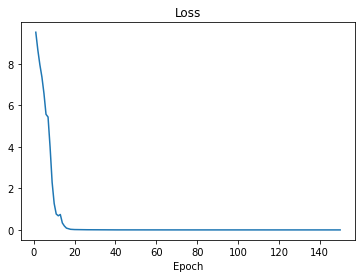

In [324]:
from matplotlib import pyplot as plt
def plot_history(losses):
    fig, ax = plt.subplots()

    epochs = np.arange(1, len(losses) + 1)

    # 損失の推移
    ax.set_title("Loss")
    ax.plot(epochs, losses)
    ax.set_xlabel("Epoch")

    plt.show()
plot_history(losses)

In [325]:
with torch.no_grad():
    X_tensor = torch.tensor(X_test, device='cuda:0').float()
            # 推論
    y_pred= np.array(model(X_tensor).cpu()).argmax(axis=1)

/home/yamada/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/home/yamada/.local/lib/python3.6/site-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [326]:
score(y_test, y_pred)

confusion matrix = 
 [[192  71]
 [ 93  49]]
accuracy =  0.5950617283950618
precision =  0.4083333333333333
recall =  0.34507042253521125
f1 score =  0.3740458015267175


- sbert + LSTM(前向き機能ベクトル固定)
    - 話題遷移エラーと判定する割合が低い

            confusion matrix = 
            [[598   4]
            [ 57   1]]
            accuracy =  0.9075757575757576
            precision =  0.2
            recall =  0.017241379310344827
            f1 score =  0.031746031746031744

- sbert + LSTM(前向き機能ベクトル学習)
    - 比較的マシになったかも

            confusion matrix = 
            [[587  15]
            [ 46  12]]
            accuracy =  0.9075757575757576
            precision =  0.4444444444444444
            recall =  0.20689655172413793
            f1 score =  0.2823529411764706

- 発話意図不明確も混ぜた
    - ちょっと無視出来ない割合で未検出(N-4)
        
            confusion matrix = 
            [[362  83]
            [125  90]]
            accuracy =  0.6848484848484848
            precision =  0.5202312138728323
            recall =  0.4186046511627907
            f1 score =  0.4639175257731959
    
    - 機能ベクトルに一度FFN を挟んだ(N=3)

            confusion matrix = 
            [[363  82]
            [109 106]]
            accuracy =  0.7106060606060606
            precision =  0.5638297872340425
            recall =  0.4930232558139535
            f1 score =  0.5260545905707196

- 学習データを，エラーシステム発話を含むものだけにした
    - 話題遷移エラーのみ

                confusion matrix = 
                [[322  25]
                [ 44  14]]
                accuracy =  0.8296296296296296
                precision =  0.358974358974359
                recall =  0.2413793103448276
                f1 score =  0.288659793814433

   - 発話意図不明確のみ

In [327]:
modelM = DataManager("../models/context_topic/")
model_name = "sbert_context_unclear.pickle"
modelM.save_data(model_name, model)

success save : ../models/context_topic/sbert_context_unclear.pickle


In [328]:
path = "../eval_labeled/"
datalist = ['DCM', 'DIT', 'IRS']
convs_ = read_conv(path, datalist)

In [329]:
# def make_Xy_4test(convs, N=4):
#     # errors = ["Topic transition error", 'Lack of information', 'Unclear intention']
#     # errors = ["Topic transition error"]
#     errors = ["Topic transition error"]
#     X = []
#     y = []
#     for conv in convs:
#         dialogue = [""]*N
#         for i, ut in enumerate( conv ) :
#             # ユーザ発話駆動
#             dialogue.append(clean_text( ut.utt) )
#             if ut.is_exist_error():
#                 X.append( dialogue[-N:] )
#                     # X.append(dialogue[-N:])
#                 if ut.is_error_included(errors) :
#                     y.append(1)
#                 else:
#                     y.append(0)
        
#     return X, y

In [330]:
N = 3
X_str, y = make_Xy_4test(convs, N=N)

In [331]:
len(X_str)

1349

In [338]:
forward_xy_eval_name = "../X_y_data/context_topic/X_forward_topic_ERROR_eval_N={0}".format(N)

In [332]:
X_forward_all_str = sum(X_str, [])

if os.path.exists(forward_xy_eval_name+".npy"):
    # X_forward_ids  = np.load(forward_xy_name+".npy")
    X_forward  = np.load(forward_xy_eval_name+".npy")
    print("success load {0}.npy".format(forward_xy_eval_name))
else:
    with torch.no_grad():
        fmodel.cpu()
        # X_forward_l =  fmodel.text2context(X_str)
        # 手で書くしかない
        x_length = len(X_forward_all_str)//N
        X_forward_ids = fmodel._make_X(X_forward_all_str, fmodel.vocab_dict).to(torch.int)
        X_forward_ids = X_forward_ids.reshape(x_length, N, -1)
        X_forward = np.array( [fmodel.last_context(Xfi).numpy() for Xfi in X_forward_ids] ) 
        # X_forward = X_forward.reshape(-1, 4, 256)
        fmodel.cuda()
        # X_forward_l = np.array( fmodel.text2context(X_forward_all_str).cpu() ) 
        # np.save(forward_xy_name, X_forward_ids)
        np.save(forward_xy_eval_name, X_forward)

100%|██████████| 4047/4047 [01:44<00:00, 38.56it/s]


In [339]:
np.save(forward_xy_eval_name, X_forward)

In [333]:
x_length = len(X_forward_all_str)//N
# X_topic_vec = smodel.encode(X_forward_all_str).reshape(x_length, N, -1)
X_topic_vec = sbert.encode(X_forward_all_str).reshape(x_length, N, -1)
X_topic = np.array([ sentence2formated(vec) for vec in X_topic_vec ])

Batches:   0%|          | 0/127 [00:00<?, ?it/s]

In [334]:
X = np.concatenate([X_topic, X_forward], axis=2)
X = torch.from_numpy(X)
y = torch.Tensor(y)

In [335]:
with torch.no_grad():
    X_tensor = torch.tensor(X, device='cuda:0').float()
    y_pred= np.array(model(X_tensor).cpu()).argmax(axis=1)

/home/yamada/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/home/yamada/.local/lib/python3.6/site-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [336]:
score(y, y_pred)

confusion matrix = 
 [[804  71]
 [ 93 381]]
accuracy =  0.8784284655300222
precision =  0.8429203539823009
recall =  0.8037974683544303
f1 score =  0.8228941684665226


- 発話意図不明確，情報不足，話題遷移エラー全て

        confusion matrix = 
        [[605  29]
        [109 606]]
        accuracy =  0.8977020014825797
        precision =  0.9543307086614173
        recall =  0.8475524475524475
        f1 score =  0.8977777777777777

- 話題遷移エラーのみ

        confusion matrix = 
        [[1132   25]
        [  44  148]]
        accuracy =  0.9488510007412898
        precision =  0.8554913294797688
        recall =  0.7708333333333334
        f1 score =  0.8109589041095892

- 発話意図不明確のみ

        confusion matrix = 
        [[804  71]
        [ 93 381]]
        accuracy =  0.8784284655300222
        precision =  0.8429203539823009
        recall =  0.8037974683544303
        f1 score =  0.8228941684665226

In [337]:
list(y).count(1)

474